In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error as mse
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from sklearn import ensemble

In [2]:
# Import data
train = pd.read_csv('train.csv', index_col = 0)
test = pd.read_csv('test.csv', index_col = 0)

print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


In [3]:
#get info

def get_details(data):
    skew= data.skew()
    corr = data.corr()['SalePrice']

    nulls = data.apply(lambda x: x.isnull().sum())
    nulls_perc = data.apply(lambda x: x.isnull().sum()/data.shape[0]*100)
    unique = data.apply(lambda x: [x.unique()])

    details = pd.concat([skew, corr, nulls, nulls_perc, unique], axis=1, sort=False)
    details.columns = ['skew', 'corr', 'nulls', 'nulls_perc', 'unique']
    
    return details

In [4]:
cat = train.select_dtypes(include=['O']).columns
cont = train.select_dtypes(exclude=['O']).columns

In [5]:
details = get_details(train[cont]).sort_values('corr', ascending = False).iloc[1:].head(12)
details

,skew,corr,nulls,nulls_perc,unique
OverallQual,0.216944,0.790982,0,0.000000,"[[7.0, 6.0, 8.0, 5.0, 9.0, 4.0, 10.0, 3.0, 1.0..."
GrLivArea,1.366560,0.708624,0,0.000000,"[[1710.0, 1262.0, 1786.0, 1717.0, 2198.0, 1362..."
GarageCars,-0.342549,0.640409,0,0.000000,"[[2.0, 3.0, 1.0, 0.0, 4.0]]"
GarageArea,0.179981,0.623431,0,0.000000,"[[548.0, 460.0, 608.0, 642.0, 836.0, 480.0, 63..."
TotalBsmtSF,1.524255,0.613581,0,0.000000,"[[856.0, 1262.0, 920.0, 756.0, 1145.0, 796.0, ..."
1stFlrSF,1.376757,0.605852,0,0.000000,"[[856.0, 1262.0, 920.0, 961.0, 1145.0, 796.0, ..."
FullBath,0.036562,0.560664,0,0.000000,"[[2.0, 1.0, 3.0, 0.0]]"
TotRmsAbvGrd,0.676341,0.533723,0,0.000000,"[[8.0, 6.0, 7.0, 9.0, 5.0, 11.0, 4.0, 10.0, 12..."
YearBuilt,-0.613461,0.522897,0,0.000000,"[[2003.0, 1976.0, 2001.0, 1915.0, 2000.0, 1993..."
YearRemodAdd,-0.503562,0.507101,0,0.000000,"[[2003.0, 1976.0, 2002.0, 1970.0, 2000.0, 1995..."


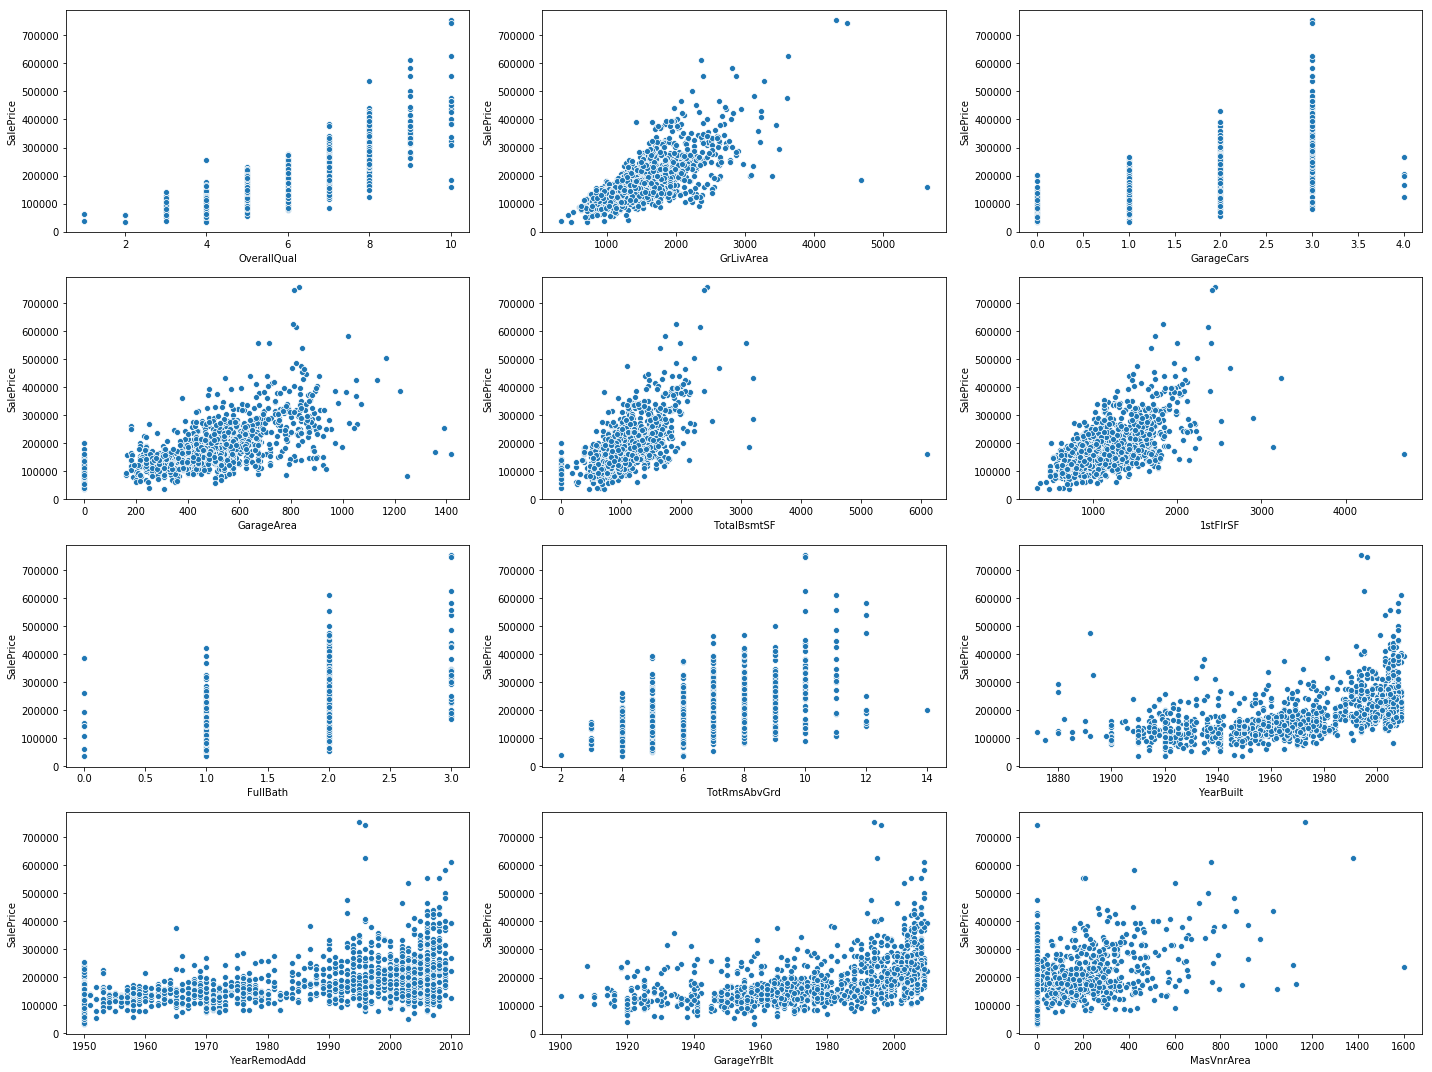

In [6]:
#scatterplot

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))

for ax, index in zip(axes.flatten(), details.index):
    sns.scatterplot(ax=ax, x = train[index], y = train.SalePrice)

plt.tight_layout(); 

In [7]:
#remove outliers

train = train.loc[train.GrLivArea <= 4500]
train = train.loc[train.TotalBsmtSF < 6000]
train = train.loc[train['1stFlrSF'] < 4000]

In [8]:
get_details(train[cont]).loc[['GarageYrBlt', 'LotFrontage']]

,skew,corr,nulls,nulls_perc,unique
GarageYrBlt,-0.648137,0.487156,81,5.555556,"[[2003.0, 1976.0, 2001.0, 1998.0, 2000.0, 1993..."
LotFrontage,1.543043,0.370584,259,17.764060,"[[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, na..."


In [9]:
#merge train and test

data = pd.concat([train, test], sort=False).reset_index(drop=True)

In [10]:
get_details(data).sort_values('nulls', ascending = False).head(10)

,skew,corr,nulls,nulls_perc,unique
PoolQC,NaN,NaN,2908,99.691464,"[[nan, Ex, Fa, Gd]]"
MiscFeature,NaN,NaN,2812,96.400411,"[[nan, Shed, Gar2, Othr, TenC]]"
Alley,NaN,NaN,2719,93.212204,"[[nan, Grvl, Pave]]"
Fence,NaN,NaN,2346,80.425094,"[[nan, MnPrv, GdWo, GdPrv, MnWw]]"
SalePrice,1.881296,1.000000,1459,50.017141,"[[208500.0, 181500.0, 223500.0, 140000.0, 2500..."
FireplaceQu,NaN,NaN,1420,48.680151,"[[nan, TA, Gd, Fa, Ex, Po]]"
LotFrontage,1.122014,0.370584,486,16.660953,"[[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, na..."
GarageCond,NaN,NaN,159,5.450806,"[[TA, Fa, nan, Gd, Po, Ex]]"
GarageFinish,NaN,NaN,159,5.450806,"[[RFn, Unf, Fin, nan]]"
GarageYrBlt,-0.381162,0.487156,159,5.450806,"[[2003.0, 1976.0, 2001.0, 1998.0, 2000.0, 1993..."


In [11]:
#impute NaN

data['PoolQC'].loc[data.PoolQC.isnull() & data.PoolArea == 0] = 'NA'
data['MiscFeature'].loc[data.MiscFeature.isnull() & (data.MiscVal == 0)] = 'NA'
data['Alley'].loc[data.Alley.isnull()] = 'NA'
data['Fence'].loc[data.Fence.isnull()] = 'NA'
data['FireplaceQu'].loc[data.FireplaceQu.isnull()] = 'NA'
data['LotFrontage'].loc[data.LotFrontage.isnull()] = 0

/home/sofiawangy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
# data = data.drop(['Utilities', 'PoolQC'], axis = 1)

In [13]:
fill = pd.Series([data[c].value_counts().index[0] for c in data[cat]],
            index=data[cat].columns)

data[cat] = data[cat].fillna(fill)

In [14]:
details = get_details(data)
details.loc[details.nulls > 0].sort_values('nulls', ascending = False)

,skew,corr,nulls,nulls_perc,unique
SalePrice,1.881296,1.000000,1459,50.017141,"[[208500.0, 181500.0, 223500.0, 140000.0, 2500..."
GarageYrBlt,-0.381162,0.487156,159,5.450806,"[[2003.0, 1976.0, 2001.0, 1998.0, 2000.0, 1993..."
MasVnrArea,2.610712,0.482719,23,0.788481,"[[196.0, 0.0, 162.0, 350.0, 186.0, 240.0, 286...."
BsmtFullBath,0.621642,0.228459,2,0.068564,"[[1.0, 0.0, 2.0, 3.0, nan]]"
BsmtHalfBath,3.930420,-0.016881,2,0.068564,"[[0.0, 1.0, 2.0, nan]]"
BsmtFinSF1,0.980788,0.409384,1,0.034282,"[[706.0, 978.0, 486.0, 216.0, 655.0, 732.0, 13..."
BsmtFinSF2,4.145816,-0.011422,1,0.034282,"[[0.0, 32.0, 668.0, 486.0, 93.0, 491.0, 506.0,..."
BsmtUnfSF,0.920173,0.214460,1,0.034282,"[[150.0, 284.0, 434.0, 540.0, 490.0, 64.0, 317..."
TotalBsmtSF,0.676548,0.651153,1,0.034282,"[[856.0, 1262.0, 920.0, 756.0, 1145.0, 796.0, ..."
GarageCars,-0.218089,0.641047,1,0.034282,"[[2.0, 3.0, 1.0, 0.0, 4.0, 5.0, nan]]"


In [15]:
fill = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']

for i in fill:
    data.loc[data[i].isnull(), i] = data.groupby(['OverallQual', 'Neighborhood'])[i].transform(lambda x: x.fillna(x.mean()))
    

In [16]:
fill = ['BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageYrBlt']

for i in fill:
    data.loc[data[i].isnull(), i] = data.groupby(['OverallQual', 'Neighborhood'])[i].transform(lambda x: x.fillna(x.median()))

In [17]:
data.loc[data['GarageYrBlt'].isnull(), 'GarageYrBlt'] = data.GarageYrBlt.median()

In [18]:
data = data.drop(['Utilities'], axis = 1)

In [19]:
cat = cat.to_list()
cat.remove('Utilities')

In [20]:
#encode categorical

# le = LabelEncoder()

# for i in cat:
#     data[i] = le.fit_transform(data[i])

# dummify categorical

dummy = pd.get_dummies(data[cat])

In [21]:
data = pd.concat([data, dummy], axis =1)
data = data.drop(cat, axis = 1)

In [22]:
data.loc[data['SalePrice'].isnull(), 'SalePrice'] = 0

details = get_details(data[cont]).sort_values('skew', ascending = False)
details

,skew,corr,nulls,nulls_perc,unique
MiscVal,21.950962,-0.017858,0,0.0,"[[0.0, 700.0, 350.0, 500.0, 400.0, 480.0, 450...."
PoolArea,17.697766,0.049490,0,0.0,"[[0.0, 512.0, 648.0, 576.0, 555.0, 519.0, 738...."
LotArea,13.116240,0.161167,0,0.0,"[[8450.0, 9600.0, 11250.0, 9550.0, 14260.0, 14..."
LowQualFinSF,12.090757,0.011117,0,0.0,"[[0.0, 360.0, 513.0, 234.0, 528.0, 572.0, 144...."
3SsnPorch,11.377932,0.046664,0,0.0,"[[0.0, 320.0, 407.0, 130.0, 180.0, 168.0, 140...."
KitchenAbvGr,4.302763,-0.043897,0,0.0,"[[1.0, 2.0, 3.0, 0.0]]"
BsmtFinSF2,4.146636,-0.019050,0,0.0,"[[0.0, 32.0, 668.0, 486.0, 93.0, 491.0, 506.0,..."
EnclosedPorch,4.004404,-0.060589,0,0.0,"[[0.0, 272.0, 228.0, 205.0, 176.0, 87.0, 172.0..."
ScreenPorch,3.947131,0.026259,0,0.0,"[[0.0, 176.0, 198.0, 291.0, 252.0, 99.0, 184.0..."
BsmtHalfBath,3.932018,-0.019090,0,0.0,"[[0.0, 1.0, 2.0]]"


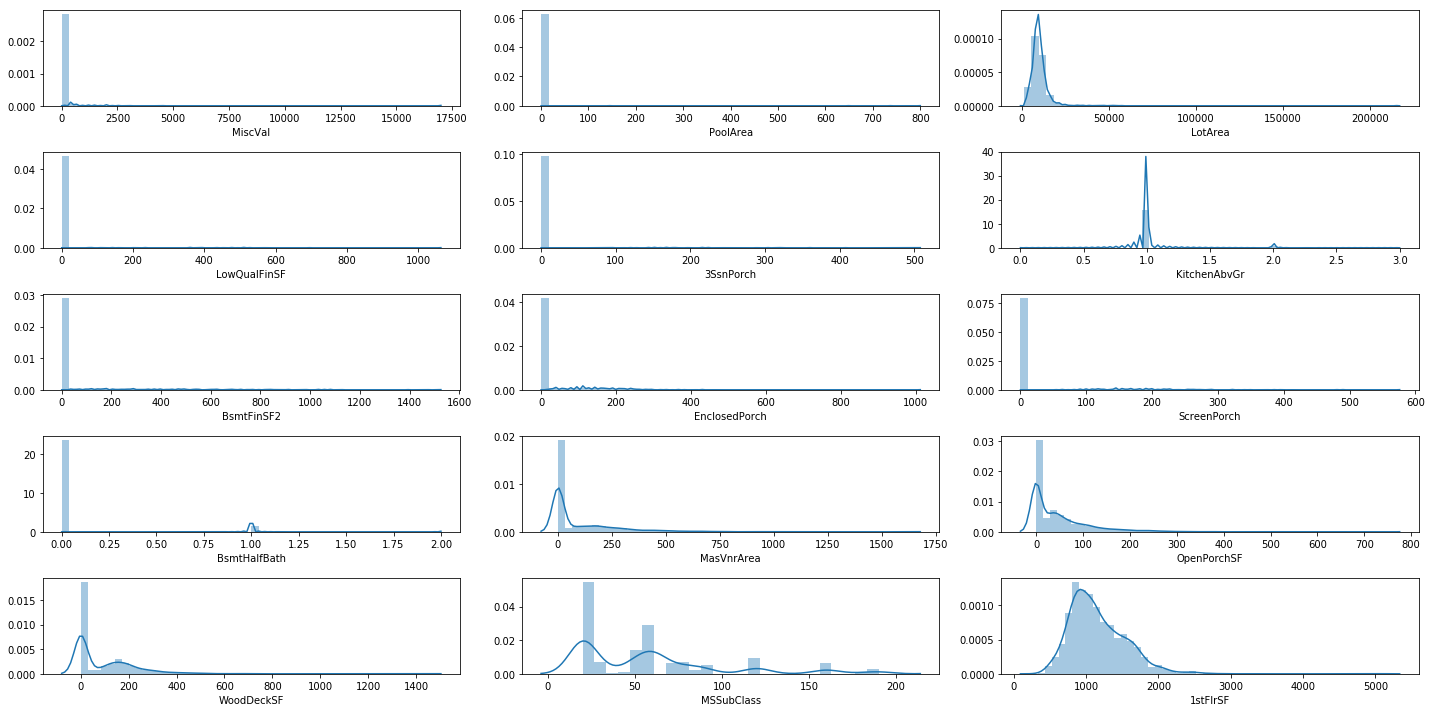

In [23]:
# graph distribution

no_log = data

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 10))

for ax, index in zip(axes.flatten(), details.head(15).index):
    sns.distplot(ax=ax, a =data[index]);

plt.tight_layout(); 

In [24]:
cols = details.loc[abs(details['skew']) > 0.7].index.to_list()
cols.remove('SalePrice')

In [25]:
# Boxcox
x = data[cols]
l_opt = {}

for i in cols:
    x.loc[:, i], l_opt[i] = boxcox(x.loc[:, i] + 1)
    
data.loc[:, 'SalePrice'], l_opt = boxcox(data.loc[:, 'SalePrice'] + 1) 

x.head()

/home/sofiawangy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,MiscVal,PoolArea,LotArea,LowQualFinSF,3SsnPorch,KitchenAbvGr,BsmtFinSF2,EnclosedPorch,ScreenPorch,BsmtHalfBath,...,OpenPorchSF,WoodDeckSF,MSSubClass,1stFlrSF,GrLivArea,BsmtFinSF1,BsmtUnfSF,2ndFlrSF,TotRmsAbvGrd,Fireplaces
0,0.0,0.0,17.941173,0.0,0.0,0.427656,0.0,0.000000,0.0,0.00000,...,4.307414,0.000000,2.660307,6.092297,8.086349,15.116940,20.225397,4.424197,2.101584,0.000000
1,0.0,0.0,18.387383,0.0,0.0,0.427656,0.0,0.000000,0.0,0.04214,...,0.000000,4.557433,2.190264,6.404851,7.730166,16.613011,27.966914,0.000000,1.870643,0.583552
2,0.0,0.0,18.953062,0.0,0.0,0.427656,0.0,0.000000,0.0,0.00000,...,3.910547,0.000000,2.660307,6.150628,8.137533,13.533952,34.554686,4.429777,1.870643,0.583552
3,0.0,0.0,18.368967,0.0,0.0,0.427656,0.0,0.769325,0.0,0.00000,...,3.718922,0.000000,2.718344,6.185840,8.091156,10.528180,38.497097,4.375007,1.993644,0.583552
4,0.0,0.0,19.822019,0.0,0.0,0.427656,0.0,0.000000,0.0,0.00000,...,4.652008,4.277659,2.660307,6.326855,8.382539,14.788167,36.694182,4.506874,2.197700,0.583552


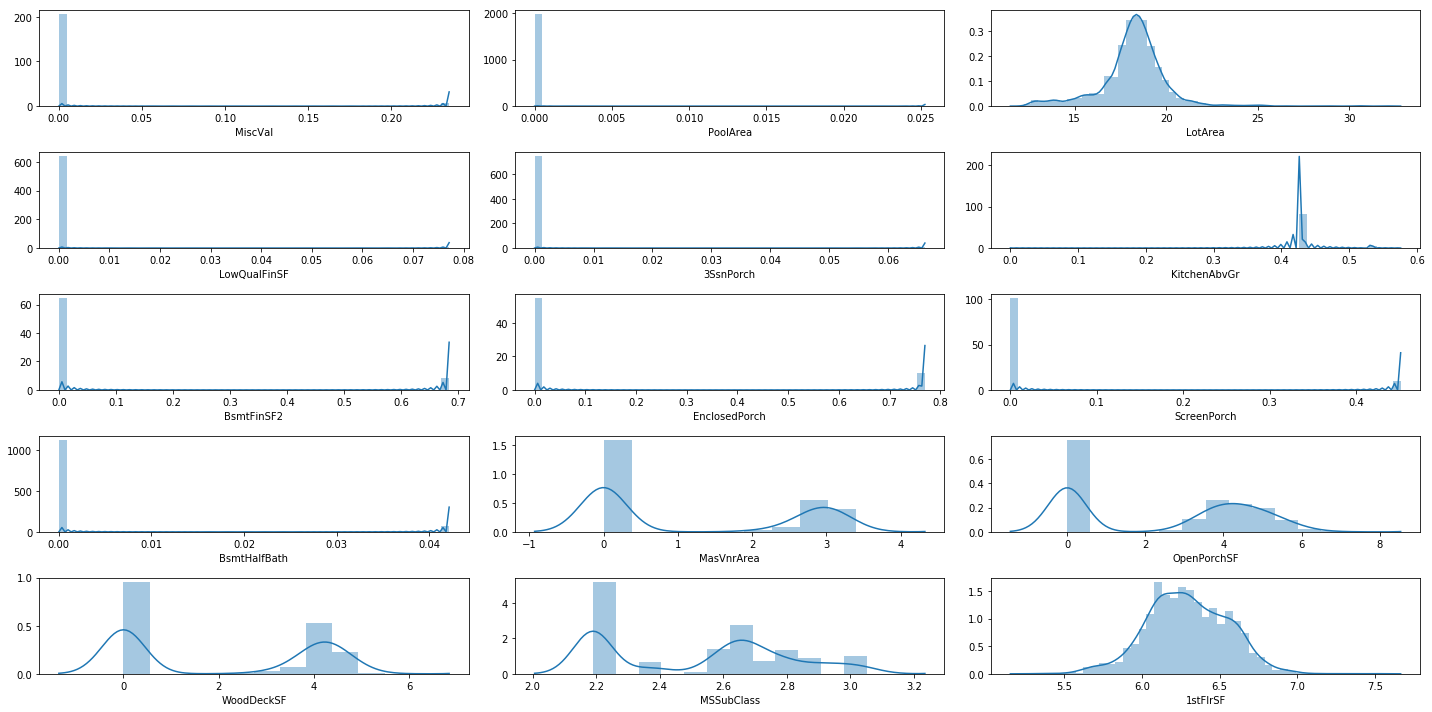

In [26]:
# graph new distribution

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 10))

for ax, index in zip(axes.flatten(), details.head(15).index):
    sns.distplot(ax=ax, a =x[index]);

plt.tight_layout(); 

In [27]:
data[cols] = x[cols]
get_details(data).sort_values('skew', ascending = False).head()

,skew,corr,nulls,nulls_perc,unique
MiscFeature_TenC,54.009258,0.019738,0,0.0,"[[0.0, 1.0]]"
Heating_Floor,54.009258,0.015969,0,0.0,"[[0.0, 1.0]]"
RoofMatl_Roll,54.009258,0.017908,0,0.0,"[[0.0, 1.0]]"
Condition2_RRAe,54.009258,0.018903,0,0.0,"[[0.0, 1.0]]"
Exterior1st_ImStucc,54.009258,0.019881,0,0.0,"[[0.0, 1.0]]"


In [28]:
data = data.drop('MiscVal', axis = 1)
data_copy = data

In [29]:
#go back to train and test
train  = data.loc[data.SalePrice > 0,]
test = data.loc[data.SalePrice == 0,]

nlog_train = no_log.loc[data.SalePrice > 0,]
nlog_test = no_log.loc[data.SalePrice == 0,]

In [30]:
# train.SalePrice, lmbda = boxcox(train.SalePrice)

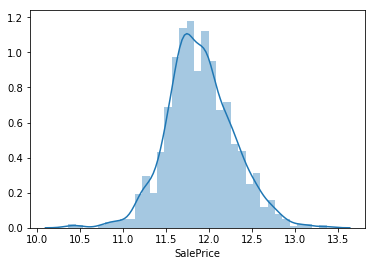

In [31]:
sns.distplot(train.SalePrice)

In [32]:
get_details(train).sort_values('corr', ascending = False)

,skew,corr,nulls,nulls_perc,unique
SalePrice,0.118585,1.000000,0,0.0,"[[12.114192780538053, 11.97850563852329, 12.18..."
OverallQual,0.200786,0.821360,0,0.0,"[[7.0, 6.0, 8.0, 5.0, 9.0, 4.0, 10.0, 3.0, 1.0..."
GrLivArea,-0.048399,0.737551,0,0.0,"[[8.086349324902526, 7.730165708821535, 8.1375..."
GarageCars,-0.342377,0.681029,0,0.0,"[[2.0, 3.0, 1.0, 0.0, 4.0]]"
GarageArea,0.131748,0.656103,0,0.0,"[[548.0, 460.0, 608.0, 642.0, 836.0, 480.0, 63..."
TotalBsmtSF,0.511703,0.647490,0,0.0,"[[856.0, 1262.0, 920.0, 756.0, 1145.0, 796.0, ..."
1stFlrSF,-0.020791,0.614834,0,0.0,"[[6.092296870312367, 6.404850537897351, 6.1506..."
FullBath,0.031271,0.595887,0,0.0,"[[2.0, 1.0, 3.0, 0.0]]"
YearBuilt,-0.612295,0.587083,0,0.0,"[[2003.0, 1976.0, 2001.0, 1915.0, 2000.0, 1993..."
YearRemodAdd,-0.501838,0.566027,0,0.0,"[[2003.0, 1976.0, 2002.0, 1970.0, 2000.0, 1995..."


In [33]:
train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,2.660307,65.0,17.941173,7,5,2003,2003,2.952854,15.116940,0.0,...,0,0,0,1,0,0,0,0,1,0
1,2.190264,80.0,18.387383,6,8,1976,1976,0.000000,16.613011,0.0,...,0,0,0,1,0,0,0,0,1,0
2,2.660307,68.0,18.953062,7,5,2001,2002,2.900159,13.533952,0.0,...,0,0,0,1,0,0,0,0,1,0
3,2.718344,60.0,18.368967,7,5,1915,1970,0.000000,10.528180,0.0,...,0,0,0,1,1,0,0,0,0,0
4,2.660307,84.0,19.822019,8,5,2000,2000,3.099116,14.788167,0.0,...,0,0,0,1,0,0,0,0,1,0


In [34]:
x = train.drop('SalePrice', axis = 1)
y = train['SalePrice']

nlog_x = nlog_train.drop('SalePrice', axis = 1)
nlog_y = nlog_train['SalePrice']

In [35]:
#pvalues

results = sm.OLS(y, x).fit()
pValues = results.pvalues
print(results.summary())

results2 = sm.OLS(nlog_y, nlog_x).fit()
pValues2 = results2.pvalues

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     94.07
Date:                Tue, 11 Feb 2020   Prob (F-statistic):               0.00
Time:                        07:11:59   Log-Likelihood:                 1477.8
No. Observations:                1458   AIC:                            -2468.
Df Residuals:                    1214   BIC:                            -1178.
Df Model:                         243                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
MSSubClass                0.00

In [36]:
pValues = list(pValues[pValues<0.05].index)
pValues2 = list(pValues2[pValues2<0.05].index)

x = x[pValues]
nlog_x = nlog_x[pValues2]

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)
nlX_train, nlX_test, nlY_train, nlY_test = train_test_split(nlog_x, nlog_y, test_size=0.2)

In [42]:
r2 = pd.DataFrame(columns= ['r2_train', 'r2_test', 'MSE'])
nlog_r2 = pd.DataFrame(columns= ['r2_train', 'r2_test', 'MSE'])

In [43]:
lm = LinearRegression()
lm.fit(X_train, Y_train)

y_pred = lm.predict(X_test)

r2.loc['Linear', 'r2_train'] = lm.score(X_train, Y_train)
r2.loc['Linear', 'r2_test'] = lm.score(X_test, Y_test)
r2.loc['Linear', 'MSE'] = mse(Y_test, y_pred)
r2

,r2_train,r2_test,MSE
Linear,0.863263,0.84369,1.35925e+09


In [44]:
lm.fit(nlX_train, nlY_train)

y_pred = lm.predict(nlX_test)

nlog_r2.loc['Linear', 'r2_train'] = lm.score(nlX_train, nlY_train)
nlog_r2.loc['Linear', 'r2_test'] = lm.score(nlX_test, nlY_test)
nlog_r2.loc['Linear', 'MSE'] = mse(nlY_test, y_pred)
nlog_r2

,r2_train,r2_test,MSE
Linear,0.860732,0.846257,1.19575e+09


Text(0.5, 1.0, 'estimated')

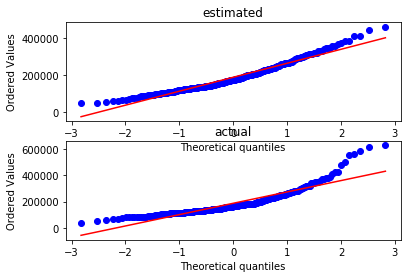

In [45]:
from scipy import stats
fig = plt.figure()
ax2 = fig.add_subplot(212)
prob = stats.probplot(Y_test, dist=stats.norm, plot=ax2)
plt.title('actual')

ax1 = fig.add_subplot(211)
prob = stats.probplot(y_pred, dist=stats.norm, plot=ax1)
plt.title('estimated')

In [46]:
x = train.drop('SalePrice', axis = 1)
y = train['SalePrice']

nlog_x = nlog_train.drop('SalePrice', axis = 1)
nlog_y = nlog_train['SalePrice']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)
nlX_train, nlX_test, nlY_train, nlY_test = train_test_split(nlog_x, nlog_y, test_size=0.2)

In [47]:
np.linspace(0.1, 10, 100)

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ])

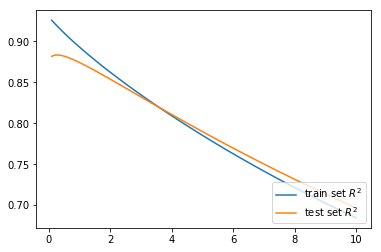

In [48]:
ridge = Ridge()

train_R2 = []
test_R2  = []
alphaRange = np.linspace(0.1, 10, 100)
for alpha in alphaRange:
    ridge.set_params(alpha=alpha, normalize=True)  
    ridge.fit(X_train, Y_train)
    train_R2.append(ridge.score(X_train, Y_train))
    test_R2.append(ridge.score(X_test, Y_test))
    
plt.plot(alphaRange, train_R2, label=r'train set $R^2$')
plt.plot(alphaRange, test_R2, label=r'test set $R^2$')
plt.legend(loc=4)

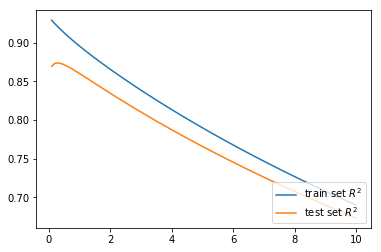

In [54]:
train_R2 = []
test_R2  = []
alphaRange = np.linspace(0.1, 10, 100)
for alpha in alphaRange:
    ridge.set_params(alpha=alpha, normalize=True)  
    ridge.fit(nlX_train, nlY_train)
    train_R2.append(ridge.score(nlX_train, nlY_train))
    test_R2.append(ridge.score(nlX_test, nlY_test))
    
plt.plot(alphaRange, train_R2, label=r'train set $R^2$')
plt.plot(alphaRange, test_R2, label=r'test set $R^2$')
plt.legend(loc=4)

In [50]:
ridge.set_params(alpha =7)
ridge.fit(X_train, Y_train)

y_pred = ridge.predict(X_test)

r2.loc['Ridge', 'r2_train'] = ridge.score(X_train, Y_train)
r2.loc['Ridge', 'r2_test'] = ridge.score(X_test, Y_test)
r2.loc['Ridge', 'MSE'] = mse(Y_test, y_pred)

ridge.set_params(alpha =1.5)
ridge.fit(nlX_train, nlY_train)

y_pred = ridge.predict(nlX_test)

nlog_r2.loc['Ridge', 'r2_train'] = ridge.score(nlX_train, nlY_train)
nlog_r2.loc['Ridge', 'r2_test'] = ridge.score(nlX_test, nlY_test)
nlog_r2.loc['Ridge', 'MSE'] = mse(nlY_test, y_pred)

r2

,r2_train,r2_test,MSE
Linear,0.863263,0.84369,1.35925e+09
Ridge,0.741585,0.75027,1.46705e+09


In [51]:
nlog_r2

,r2_train,r2_test,MSE
Linear,0.860732,0.846257,1.19575e+09
Ridge,0.880111,0.847295,8.94612e+08


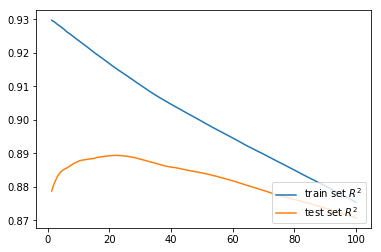

In [52]:
lasso = Lasso()

train_R2 = []
test_R2  = []
alphaRange = np.logspace(0.1, 2, 100)
for alpha in alphaRange:
    lasso.set_params(alpha=alpha, normalize=True)  
    lasso.fit(X_train, Y_train)
    train_R2.append(lasso.score(X_train, Y_train))
    test_R2.append(lasso.score(X_test, Y_test))
    
plt.plot(alphaRange, train_R2, label=r'train set $R^2$')
plt.plot(alphaRange, test_R2, label=r'test set $R^2$')
plt.legend(loc=4)   

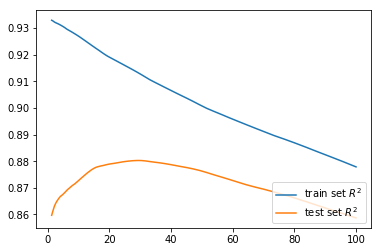

In [55]:
train_R2 = []
test_R2  = []
alphaRange = np.logspace(0.1, 2, 100)
for alpha in alphaRange:
    lasso.set_params(alpha=alpha, normalize=True)  
    lasso.fit(nlX_train, nlY_train)
    train_R2.append(lasso.score(nlX_train, nlY_train))
    test_R2.append(lasso.score(nlX_test, nlY_test))
    
plt.plot(alphaRange, train_R2, label=r'train set $R^2$')
plt.plot(alphaRange, test_R2, label=r'test set $R^2$')
plt.legend(loc=4)   

In [56]:
lasso.set_params(alpha=100)
lasso.fit(X_train, Y_train)

y_pred = lasso.predict(X_test)

r2.loc['Lasso', 'r2_train'] = lasso.score(X_train, Y_train)
r2.loc['Lasso', 'r2_test'] = lasso.score(X_test, Y_test)
r2.loc['Lasso', 'MSE'] = mse(Y_test, y_pred)

lasso.set_params(alpha=65)
lasso.fit(nlX_train, nlY_train)

y_pred = lasso.predict(nlX_test)

nlog_r2.loc['Lasso', 'r2_train'] = lasso.score(nlX_train, nlY_train)
nlog_r2.loc['Lasso', 'r2_test'] = lasso.score(nlX_test, nlY_test)
nlog_r2.loc['Lasso', 'MSE'] = mse(nlY_test, y_pred)

r2

,r2_train,r2_test,MSE
Linear,0.863263,0.84369,1.35925e+09
Ridge,0.741585,0.75027,1.46705e+09
Lasso,0.875407,0.870684,7.59674e+08


In [57]:
nlog_r2

,r2_train,r2_test,MSE
Linear,0.860732,0.846257,1.19575e+09
Ridge,0.880111,0.847295,8.94612e+08
Lasso,0.893453,0.870958,7.55987e+08


In [60]:
net = ElasticNet()

alphaSize  = 100
rhoSize    = 100
alphaRange = np.linspace(5, 100, 100)
rhoRange   = np.linspace(5, 100, 100)
trainR2    = np.zeros((alphaSize, rhoSize))
testR2     = np.zeros((alphaSize, rhoSize))
net.set_params(normalize=True)

for alphaIdx, alpha in enumerate(alphaRange):
    for rhoIdx, rho in enumerate(rhoRange):
        net.set_params(alpha=alpha, l1_ratio=rho)
        net.fit(X_train, Y_train)
        trainR2[alphaIdx, rhoIdx] = net.score(X_train, Y_train)
        testR2[alphaIdx, rhoIdx]  = net.score(X_test, Y_test)

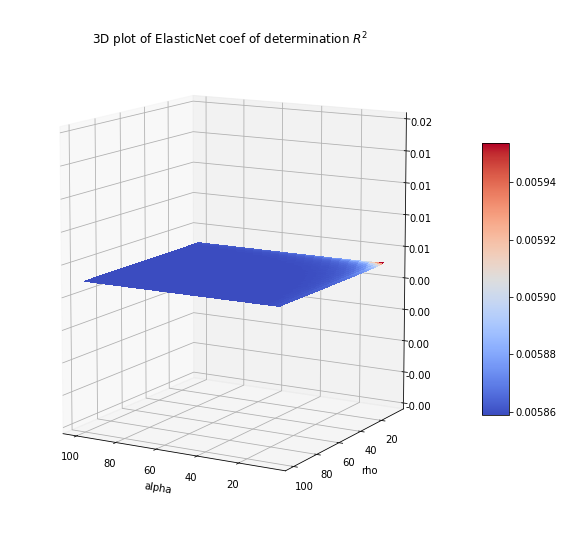

In [54]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

# Make data
x = alphaRange
y = rhoRange
X, Y = np.meshgrid(x, y)
Z = (trainR2-testR2).T
# Z = (trainR2).T
# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(np.min(Z) - 0.01, np.max(Z) + 0.01)
ax.view_init(10, 120)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.xlabel('alpha')
plt.ylabel('rho')
plt.title(r'3D plot of ElasticNet coef of determination $R^2$')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

In [61]:
net.set_params(alpha=85, l1_ratio=1)
net.fit(X_train, Y_train)

y_pred = net.predict(X_test)

print(net.score(X_train, Y_train))
print(net.score(X_test, Y_test))

r2.loc['ElasticNet', 'r2_train'] = net.score(X_train, Y_train)
r2.loc['ElasticNet', 'r2_test'] = net.score(X_test, Y_test)
r2.loc['ElasticNet', 'MSE'] = mse(Y_test, y_pred)
r2

0.9142949544729081
0.898847099096836


,r2_train,r2_test,MSE
Linear,0.863263,0.84369,1.35925e+09
Ridge,0.741585,0.75027,1.46705e+09
Lasso,0.875407,0.870684,7.59674e+08
ElasticNet,0.914295,0.898847,5.94226e+08


In [56]:
trainR2    = np.zeros((alphaSize, rhoSize))
testR2     = np.zeros((alphaSize, rhoSize))

for alphaIdx, alpha in enumerate(alphaRange):
    for rhoIdx, rho in enumerate(rhoRange):
        net.set_params(alpha=alpha, l1_ratio=rho)
        net.fit(nlX_train, nlY_train)
        trainR2[alphaIdx, rhoIdx] = net.score(nlX_train, nlY_train)
        testR2[alphaIdx, rhoIdx]  = net.score(nlX_test, nlY_test)
        
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

# Make data
x = alphaRange
y = rhoRange
X, Y = np.meshgrid(x, y)
Z = (trainR2-testR2).T
# Z = (trainR2).T
# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(np.min(Z) - 0.01, np.max(Z) + 0.01)
ax.view_init(10, 120)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.xlabel('alpha')
plt.ylabel('rho')
plt.title(r'3D plot of ElasticNet coef of determination $R^2$')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)  

KeyboardInterrupt: 

In [62]:
net.set_params(alpha=50, l1_ratio=1)
net.fit(nlX_train, nlY_train)

y_pred = net.predict(nlX_test)

print(net.score(nlX_train, nlY_train))
print(net.score(nlX_test, nlY_test))

nlog_r2.loc['ElasticNet', 'r2_train'] = net.score(nlX_train, nlY_train)
nlog_r2.loc['ElasticNet', 'r2_test'] = net.score(nlX_test, nlY_test)
nlog_r2.loc['ElasticNet', 'MSE'] = mse(nlY_test, y_pred)
nlog_r2

0.9197487268719124
0.8893365064389164


,r2_train,r2_test,MSE
Linear,0.860732,0.846257,1.19575e+09
Ridge,0.880111,0.847295,8.94612e+08
Lasso,0.893453,0.870958,7.55987e+08
ElasticNet,0.919749,0.889337,6.48316e+08


In [63]:
x = train.drop('SalePrice', axis = 1)
y = train['SalePrice']

nlog_x = nlog_train.drop('SalePrice', axis = 1)
nlog_y = nlog_train['SalePrice']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)
nlX_train, nlX_test, nlY_train, nlY_test = train_test_split(nlog_x, nlog_y, test_size=0.2)

In [64]:
from sklearn import tree

tree_model = tree.DecisionTreeClassifier(random_state=42)
tree_model.fit(nlX_train, nlY_train)
print('train tree: ', tree_model.score(nlX_train, nlY_train))
print('test tree: ', tree_model.score(nlX_test, nlY_test))

train tree:  1.0
test tree:  0.010273972602739725


In [65]:
fig = tree_model.fit(nlX_train, nlY_train)
tree.plot_tree(fig)
# plt.show()
# tree.convert_to_graphviz(fig)

AttributeError: module 'sklearn.tree' has no attribute 'plot_tree'

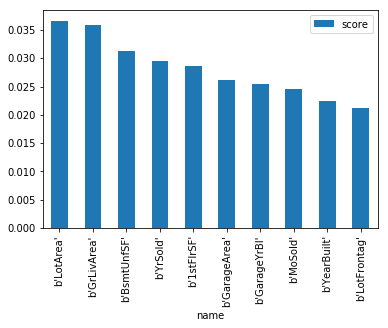

In [348]:
feature_importance = list(zip(nlog_train.columns, tree_model.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name,'score':score})[:10].plot.bar(x='name', y='score')


In [349]:
cols = ['LotArea', 'GrLivArea', 'BsmtUnfSF', 'YrSold', '1stFlrSF', 
        'GarageArea', 'GarageYrBlt', 'MoSold', 'YearBuilt', 'LotFrontage']
#     'TotalBsmtSF', 'BsmtFinSF1',
#         'YearRemodAdd'
nlX_train = nlX_train[cols]
nlX_test = nlX_test[cols]

tree_model.fit(nlX_train, nlY_train)
print('train tree: ', tree_model.score(nlX_train, nlY_train))
print('test tree: ', tree_model.score(nlX_test, nlY_test))

train tree:  0.9991423670668954
test tree:  0.023972602739726026


In [350]:
from sklearn.model_selection import GridSearchCV

grid_para_tree = [{
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int)
}]
tree_model.set_params(random_state=108)
grid_search_tree = GridSearchCV(tree_model, grid_para_tree, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_tree.fit(nlX_train, nlY_train)

print(grid_search_tree.best_params_)
print(grid_search_tree.best_score_)
print(grid_search_tree.score(nlX_train, nlY_train))
print(grid_search_tree.score(nlX_test, nlY_test))

/home/sofiawangy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


KeyboardInterrupt: 

In [74]:
tree_model.set_params(random_state=108, criterion='gini', min_samples_leaf = 8, min_samples_split = 2)
tree_model.fit(nlX_train, nlY_train)

y_pred = tree_model.predict(nlX_test)

nlog_r2.loc['Tree', 'r2_train'] = tree_model.score(nlX_train, nlY_train)
nlog_r2.loc['Tree', 'r2_test'] = tree_model.score(nlX_test, nlY_test)
nlog_r2.loc['Tree', 'MSE'] = mse(nlY_test, y_pred)
nlog_r2

,r2_train,r2_test,MSE
Linear,0.863002,0.84758,9.579e+08
Ridge,0.860824,0.843981,9.80514e+08
Lasso,0.863002,0.847577,9.57918e+08
ElasticNet,0.862996,0.847287,9.59739e+08
Tree,0.194683,0.0136986,3.84917e+09


In [75]:
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_train, Y_train)
print('train tree: ', tree_model.score(X_train, Y_train))
print('test tree: ', tree_model.score(X_test, Y_test))

train tree:  1.0
test tree:  0.010273972602739725


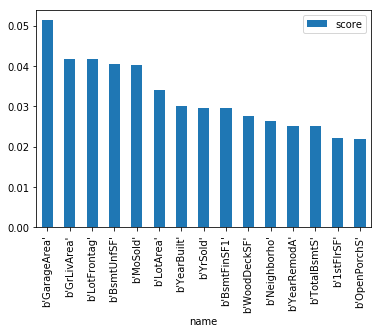

In [76]:
feature_importance = list(zip(train.columns, tree_model.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name,'score':score})[:15].plot.bar(x='name', y='score')

In [78]:
cols = ['GarageArea', 'GrLivArea', 'LotFrontage', 'BsmtUnfSF', 'MoSold', 
        'LotArea', 'YearBuilt', 'YrSold', 'BsmtFinSF1', 'WoodDeckSF']
    
X_train = X_train[cols]
X_test = X_test[cols]

tree_model.fit(X_train, Y_train)
print('train tree: ', tree_model.score(X_train, Y_train))
print('test tree: ', tree_model.score(X_test, Y_test))

train tree:  0.9982847341337907
test tree:  0.00684931506849315


In [79]:
grid_para_tree = [{
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int)
}]
tree_model.set_params(random_state=108)
grid_search_tree = GridSearchCV(tree_model, grid_para_tree, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_tree.fit(X_train, Y_train)

print(grid_search_tree.best_params_)
print(grid_search_tree.best_score_)
print(grid_search_tree.score(X_train, Y_train))
print(grid_search_tree.score(X_test, Y_test))

/home/sofiawangy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


{'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 22}
0.016295025728987993
0.19125214408233276
0.0136986301369863


/home/sofiawangy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [80]:
tree_model.set_params(random_state=108, criterion='gini', min_samples_leaf = 5, min_samples_split = 2)
tree_model.fit(X_train, Y_train)

y_pred = tree_model.predict(X_test)

r2.loc['Tree', 'r2_train'] = tree_model.score(X_train, Y_train)
r2.loc['Tree', 'r2_test'] = tree_model.score(X_test, Y_test)
r2.loc['Tree', 'MSE'] = mse(Y_test, y_pred)
r2

,r2_train,r2_test,MSE
Linear,0.860425,0.857217,9.37826e+08
Ridge,0.858224,0.858087,9.32113e+08
Lasso,0.857857,0.852951,9.65845e+08
ElasticNet,0.860425,0.857215,9.37837e+08
Tree,0.270154,0.0171233,3.60993e+09


In [356]:
x = train.drop('SalePrice', axis = 1)
y = train['SalePrice']

x = x[pValues]

nlog_x = nlog_train.drop('SalePrice', axis = 1)
nlog_y = nlog_train['SalePrice']

nlog_x = nlog_x[pValues2]

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)
nlX_train, nlX_test, nlY_train, nlY_test = train_test_split(nlog_x, nlog_y, test_size=0.2)

/home/sofiawangy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


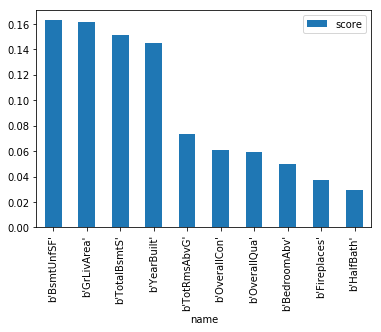

In [359]:
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, Y_train)

feature_importance = list(zip(x.columns, rf.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name,'score':score})[:10].plot.bar(x='name', y='score')


In [361]:
cols = ['BsmtUnfSF', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'TotRmsAbvGrd', 'OverallQual', 'OverallCond', 
        'BedroomAbvGr', 'Fireplaces', 'HalfBath']
    
X_train = X_train[cols]
X_test = X_test[cols]

rf.fit(X_train, Y_train)
print('train tree: ', rf.score(X_train, Y_train))
print('test tree: ', rf.score(X_test, Y_test))

train tree:  0.9922813036020584
test tree:  0.02054794520547945


In [363]:
grid_para_tree = [{
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=5, stop=30, num=15, dtype=int)
}]
tree_model.set_params(random_state=108)
grid_search_tree = GridSearchCV(rf, grid_para_tree, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_tree.fit(X_train, Y_train)
print(grid_search_tree.best_params_)
print(grid_search_tree.best_score_)
print(grid_search_tree.score(X_train, Y_train))
print(grid_search_tree.score(X_test, Y_test))

/home/sofiawangy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


{'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 21}
0.024871355060034305
0.5222984562607204
0.00684931506849315


/home/sofiawangy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


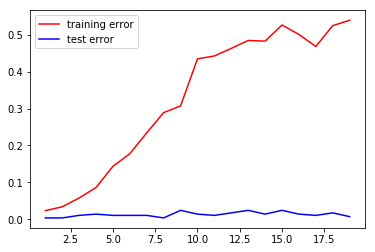

In [364]:
depth = range(1, 20)
train_error2 = []
test_error2 = []

for i in depth:
    rf.set_params(max_depth=i, criterion= 'gini', min_samples_leaf=5, min_samples_split= 21)
    rf.fit(X_train, Y_train)
    train_error2.append(rf.score(X_train, Y_train))
    test_error2.append(rf.score(X_test, Y_test))

plt.plot(depth, train_error2, c='red', label='training error')
plt.plot(depth, test_error2, c='blue', label='test error')
plt.legend()
plt.show()

In [366]:
rf.set_params(random_state=108, criterion='gini', min_samples_leaf = 5, min_samples_split = 21, max_depth=1)
rf.fit(X_train, Y_train)

y_pred = rf.predict(X_test)

r2.loc['RF', 'r2_train'] = rf.score(X_train, Y_train)
r2.loc['RF', 'r2_test'] = rf.score(X_test, Y_test)
r2.loc['RF', 'MSE'] = mse(Y_test, y_pred)
r2

,r2_train,r2_test,MSE
Linear,0.835788,0.863308,9.04295e+08
Ridge,0.744046,0.74287,1.51284e+09
Lasso,0.878653,0.856448,8.44592e+08
ElasticNet,0.885738,0.860937,8.18186e+08
RF,0.0205832,0.00684932,6.92068e+09


/home/sofiawangy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


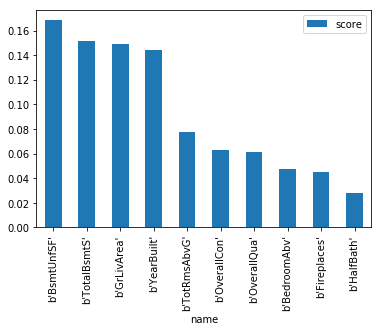

In [368]:
rf = ensemble.RandomForestClassifier()
rf.fit(nlX_train, nlY_train)

feature_importance = list(zip(nlog_x.columns, rf.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name,'score':score})[:10].plot.bar(x='name', y='score')

In [370]:
cols = ['BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea', 'YearBuilt', 'TotRmsAbvGrd', 'OverallCond', 'OverallQual',
        'BedroomAbvGr', 'Fireplaces', 'HalfBath']

nlX_train = nlX_train[cols]
nlX_test = nlX_test[cols]

rf.fit(nlX_train, nlY_train)
print('train tree: ', rf.score(nlX_train, nlY_train))
print('test tree: ', rf.score(nlX_test, nlY_test))

train tree:  0.9888507718696398
test tree:  0.017123287671232876


In [371]:
grid_para_tree = [{
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=5, stop=30, num=15, dtype=int)
}]
rf.set_params(random_state=42)
grid_search_tree = GridSearchCV(rf, grid_para_tree, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_tree.fit(nlX_train, nlY_train)

print(grid_search_tree.best_params_)
print(grid_search_tree.best_score_)
print(grid_search_tree.score(nlX_train, nlY_train))
print(grid_search_tree.score(nlX_test, nlY_test))

/home/sofiawangy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/sofiawangy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'entropy', 'min_samples_leaf': 3, 'min_samples_split': 12}
0.02058319039451115
0.6397941680960549
0.00684931506849315


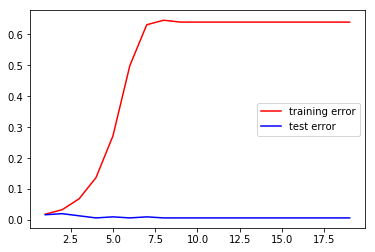

In [372]:
depth = range(1, 20)
train_error2 = []
test_error2 = []

for i in depth:
    rf.set_params(max_depth=i, criterion= 'entropy', min_samples_leaf=3, min_samples_split= 12)
    rf.fit(nlX_train, nlY_train)
    train_error2.append(rf.score(nlX_train, nlY_train))
    test_error2.append(rf.score(nlX_test, nlY_test))

plt.plot(depth, train_error2, c='red', label='training error')
plt.plot(depth, test_error2, c='blue', label='test error')
plt.legend()
plt.show()

In [374]:
rf.set_params(random_state=108, criterion='entropy', min_samples_leaf=3, min_samples_split= 12, max_depth=2)
rf.fit(nlX_train, nlY_train)

y_pred = rf.predict(nlX_test)

nlog_r2.loc['RF', 'r2_train'] = rf.score(nlX_train, nlY_train)
nlog_r2.loc['RF', 'r2_test'] = rf.score(nlX_test, nlY_test)
nlog_r2.loc['RF', 'MSE'] = mse(nlY_test, y_pred)
nlog_r2

,r2_train,r2_test,MSE
Linear,0.837389,0.847047,1.04284e+09
Ridge,0.874919,0.873935,8.86059e+08
Lasso,0.889432,0.889914,7.73746e+08
ElasticNet,0.897641,0.893977,7.45188e+08
RF,0.0360206,0.010274,3.52946e+09


In [350]:
from xgboost import XGBClassifier

xgX_train, xgX_test, xgY_train, xgY_test = train_test_split(train.iloc[:,:-1], train.iloc[:,-1], test_size=0.2)

xgboost = XGBClassifier()
randomForest.set_params(random_state=42, n_estimators=100)
randomForest.fit(xgX_train, xgY_test)

# feature_importance = list(zip(rfX_train.columns, randomForest.feature_importances_))
# dtype = [('feature', 'S10'), ('importance', 'float')]
# feature_importance = np.array(feature_importance, dtype=dtype)
# feature_sort = np.sort(feature_importance, order='importance')[::-1]
# name, score = zip(*list(feature_sort))
# pd.DataFrame({'name':name,'score':score})[:15].plot.bar(x='name', y='score')

ModuleNotFoundError: No module named 'xgboost'

In [310]:
r2

,r2_train,r2_test,MSE
Linear,0.915042,0.885687,0.00274211
Ridge,0.915042,0.885687,0.00274211
Lasso,0.914918,0.885862,0.00273792
ElasticNet,0.90506,0.881251,0.00284853
